In [ ]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score


In [4]:
df = pd.read_excel("output/data_train.xlsx")
df = df.set_index("Unnamed: 0")
df.index.names = ["id"]
df.head()

,m1,m2,m3,s1__longest_strike_below_mean,s1__autocorrelation__lag_8,s1__autocorrelation__lag_3,s1__autocorrelation__lag_9,s1__autocorrelation__lag_4,s1__autocorrelation__lag_7,s1__longest_strike_above_mean,...,s1__ar_coefficient__coeff_10__k_10,s1__partial_autocorrelation__lag_4,"s1__fft_coefficient__attr_""abs""__coeff_11","s1__agg_autocorrelation__f_agg_""var""__maxlag_40","s1__fft_coefficient__attr_""abs""__coeff_12",s1__spkt_welch_density__coeff_2,s1__approximate_entropy__m_2__r_0.1,y1,y2,y3
id,,,,,,,,,,,,,,,,,,,,,
E001,181.804696,1094.717447,1.779954,17,0.085037,0.846710,-0.099622,0.734440,0.266795,17,...,0.238101,-0.342261,46.553048,0.502834,33.749551,1.525904e-03,0.101777,70.649287,0.760144,137.904098
E002,108.654462,1272.111237,1.246933,12,-0.588300,0.675084,-0.785241,0.450297,-0.347499,12,...,0.313434,-0.365200,30.644158,0.478229,276.483695,2.085124e-05,0.145355,45.756098,1.308620,90.775544
E003,198.412419,1042.479529,2.860727,11,-0.671287,0.654112,-0.855068,0.410677,-0.431519,11,...,0.174380,-0.382007,11.951961,0.466444,32.455735,5.641745e-07,0.176679,56.394783,1.134736,0.303491
E004,132.123815,1250.168114,1.338401,20,0.249721,0.877051,0.088855,0.787166,0.403946,19,...,0.255874,-0.331380,8.950125,0.514807,7.036999,3.237022e-03,0.139121,69.819631,0.767338,190.322529
E005,116.803570,1184.972285,1.418379,16,0.009386,0.836367,-0.185819,0.713436,0.204210,16,...,0.202000,-0.359062,14.841333,0.476677,11.629828,1.894488e-04,0.114818,59.082048,0.873224,143.095112


In [5]:
colsY = ["y1", "y2", "y3"]
colsX = [c for c in df.columns if c not in colsY]

X = df[colsX]
Y = df[colsY]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print(X_train.shape)
print(Y_train.shape)


(35, 49)
(35, 3)


In [6]:
scX = MinMaxScaler()
X_train_std = scX.fit_transform(X_train)
X_test_std = scX.transform(X_test)

scY = MinMaxScaler()
Y_train_std = scY.fit_transform(Y_train)
Y_test_std = scY.transform(Y_test)

In [7]:
# Convert to 2D PyTorch tensors
X_train_std = torch.tensor(X_train_std, dtype=torch.float32)
Y_train_std = torch.tensor(Y_train_std, dtype=torch.float32)
X_test_std = torch.tensor(X_test_std, dtype=torch.float32)
Y_test_std = torch.tensor(Y_test_std, dtype=torch.float32)

In [ ]:
# Define the model
model = nn.Sequential(
    nn.Linear(X.shape[1], 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, Y.shape[1]),
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

MSE: 0.01
RMSE: 0.07


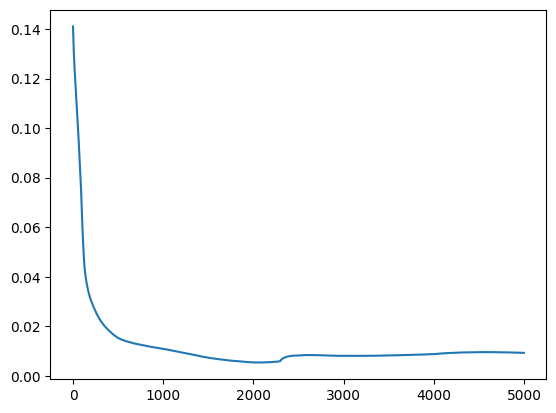

In [ ]:
n_epochs = 5000  # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf  # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train_std[start : start + batch_size]
            y_batch = Y_train_std[start : start + batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test_std)
    mse = loss_fn(y_pred, Y_test_std)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [10]:
def _residual(ax, y_pred, y, title, color="steelblue"):
    ax.scatter(y_pred, y_pred - y, c=color, marker="o", edgecolor="white", s=70)
    ax.hlines(y=0, xmin=-10, xmax=50, color="black", lw=2)
    ax.axes.set_aspect("equal")
    ax.set_title(title)


def plot_res(y_train, y_test, y_train_pred, y_test_pred):
    fig, ax = plt.subplots(
        1, 2, figsize=(9, 3), constrained_layout=True, sharex=True, sharey=True
    )
    _residual(ax=ax[0], y_pred=y_train_pred, y=y_train, title="Train")
    _residual(ax=ax[1], y_pred=y_test_pred, y=y_test, title="Test", color="limegreen")
    ax[0].set_xlim([-2, 2])
    fig.supxlabel("Predicted values")
    fig.supylabel("Residual")


def store_results(y_train, y_test, y_train_pred, y_test_pred):
    MSE_train = mean_squared_error(y_train, y_train_pred)
    MSE_test = mean_squared_error(y_test, y_test_pred)

    R2_train = r2_score(y_train, y_train_pred)
    R2_test = r2_score(y_test, y_test_pred)

    data = {
        "MSE Train": MSE_train,
        "MSE Test": MSE_test,
        "R2 Train": R2_train,
        "R2 Test": R2_test,
    }
    return data

In [11]:
Y_train_pred = model(X_train_std)
Y_test_pred = model(X_test_std)

,MSE Train,MSE Test,R2 Train,R2 Test
0,0.001220,0.004702,0.985170,0.915803
1,0.000610,0.006444,0.993535,0.901942
2,0.000282,0.005181,0.996494,0.928354


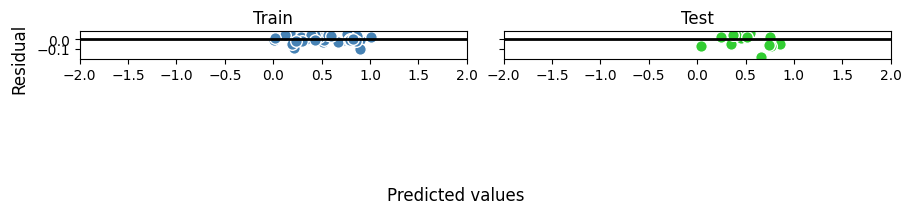

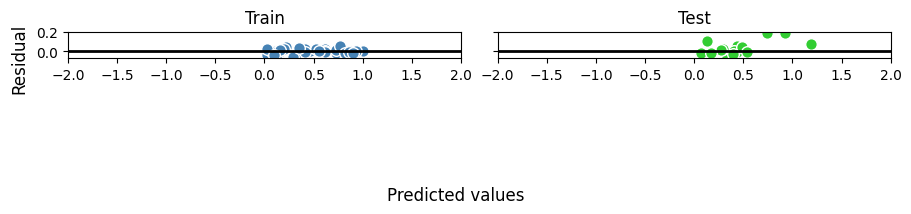

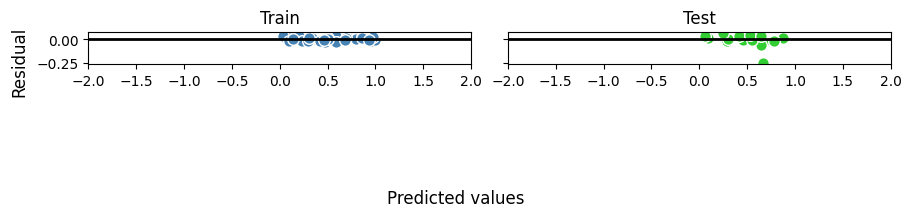

In [12]:
Y_train_std = Y_train_std.detach().numpy()
Y_test_std = Y_test_std.detach().numpy()
Y_train_pred = Y_train_pred.detach().numpy()
Y_test_pred = Y_test_pred.detach().numpy()

resArr = []
for i in range(Y.shape[1]):
    y_train = Y_train_std[:, i]
    y_test = Y_test_std[:, i]
    y_train_pred = Y_train_pred[:, i]
    y_test_pred = Y_test_pred[:, i]
    plot_res(y_train, y_test, y_train_pred, y_test_pred)
    res = store_results(y_train, y_test, y_train_pred, y_test_pred)
    resArr.append(res)

dfRes = pd.DataFrame.from_dict(resArr)
dfRes